In [1]:
import pandas as pd
data = pd.read_csv('IMDB-Dataset.csv')
if any(data.duplicated()):
    data = data.drop_duplicates()


In [2]:
# Xóa html, dấu câu, số, icon, stopword. Tạo chuyển contraction, đưa về từ nguyên bản (Lemmatize)
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text,'html.parser')
    text = soup.get_text() # Xóa thẻ html
    text = expand_contractions(text) # mở rộng các từ viết tắt,...

    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F" # emoticons
                             u"\U0001F300-\U0001F5FF" # symbols & pictogragh
                             u"\U0001F680-\U0001F6FF" # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF" # flags (iOs)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text) # Xoa emoji
    text = re.sub(r'\.(?=\S)','. ',text) # Them space sau dau .
    text = re.sub(r'http\S+','',text) # Xoa urls
    text = ''.join([letter.lower() for letter in text if letter not in string.punctuation]) # Loai bo dau cau
    text = ' '.join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) # Dua tu ve nguyen ban
    return text

In [4]:
data['review'] = data['review'].apply(preprocess_text)

C:\Users\Acer\AppData\Local\Temp\ipykernel_22368\977855826.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text,'html.parser')


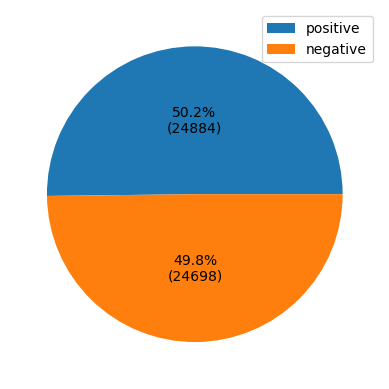

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def format_pct(pct, allvalues):
    absolute = int(pct/100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct,absolute)

num_pos = len(data[data['sentiment'] == 'positive'])
num_neg = len(data[data['sentiment'] == 'negative'])

sta = [num_pos, num_neg]
labels = ['positive','negative']

plt.pie(x=sta, autopct=lambda pct: format_pct(pct, sta), pctdistance=0.5)
plt.legend(labels, loc='best')
plt.savefig('PieChart.png')
plt.show()

c:\Users\Acer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


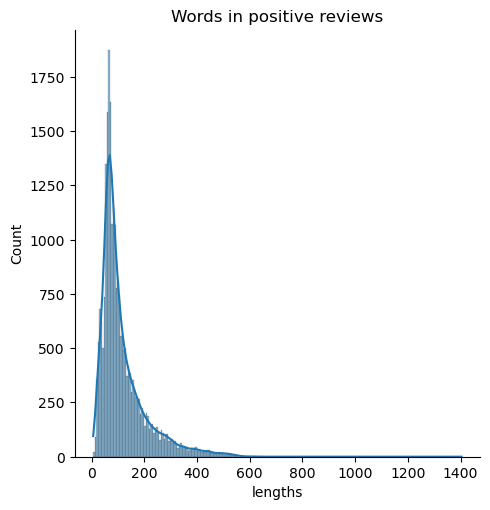

c:\Users\Acer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


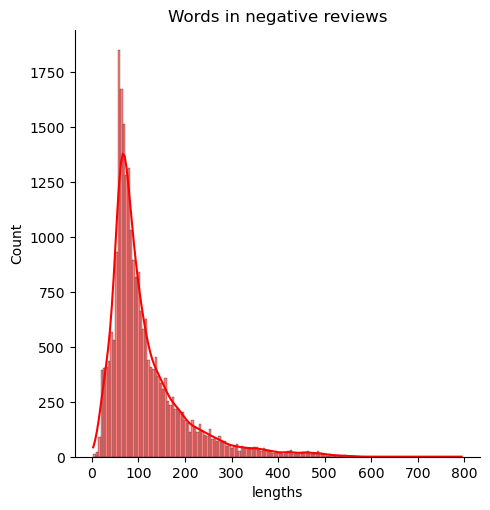

c:\Users\Acer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


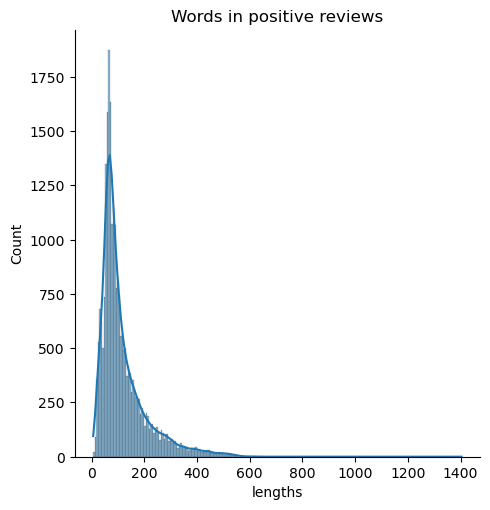

c:\Users\Acer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


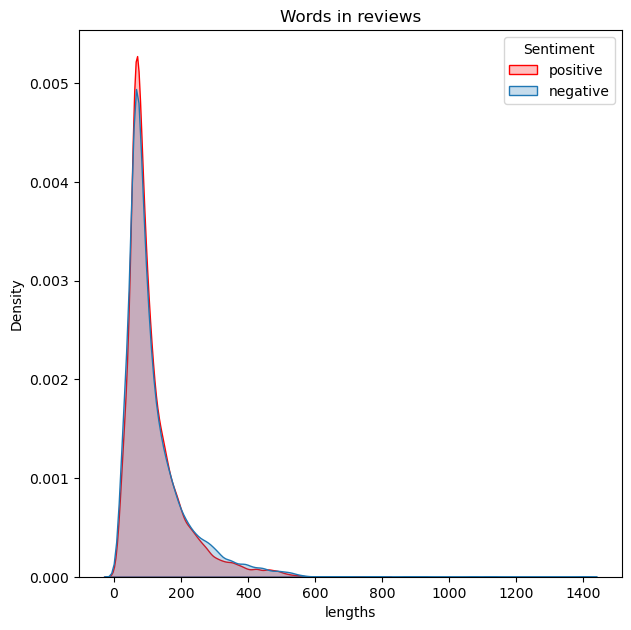

In [45]:
word_lens = data['review'].str.split().map(lambda x: len(x))
data_temp = data.copy()
data_temp['lengths'] = word_lens

hist_positive = sns.displot(data=data_temp[data_temp['sentiment'] == 'positive'], x='lengths', hue='sentiment', kde=True,legend=False).set(title='Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(data=data_temp[data_temp['sentiment'] == 'negative'], x='lengths', hue='sentiment', kde=True, legend=False,palette=['red']).set(title='Words in negative reviews')
plt.show(hist_negative)

hist_positive = sns.displot(data=data_temp[data_temp['sentiment'] == 'positive'], x='lengths', hue='sentiment', kde=True,legend=False).set(title='Words in positive reviews')
plt.show(hist_positive)


plt.figure(figsize=(7,7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=data_temp, x='lengths', hue='sentiment', fill=True, palette=[sns.color_palette()[0],'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['positive','negative'])
plt.show(kernel_distribution_number_words_plot)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_data= le.fit_transform(data['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(data['review'], y_data, test_size=0.2, random_state=42)


In [47]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train,y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt_classifier.fit(x_train_encoded,y_train)

0.7180598971463145


In [50]:
y_pred = dt_classifier.predict(x_test_encoded)
print(accuracy_score(y_pred,y_test))

0.7180598971463145


In [51]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_encoded,y_train)

RandomForestClassifier(random_state=42)

In [52]:
y_pred = rf_classifier.predict(x_test_encoded)
print(accuracy_score(y_pred,y_test))

0.8420893415347384


In [53]:
df = pd.read_csv('IMDB-Dataset.csv')
print(len(df[df.duplicated()]))

418
